In [2]:
from tools.base import *
from tools.ddmtd import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import sleep 
from copy import deepcopy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
import matplotlib
matplotlib.style.available
matplotlib.style.use(['seaborn-darkgrid','science'])
# plt.rcParams['figure.figsize'] = [4, 3]
plt.rcParams['figure.dpi'] = 300

In [3]:
bin(6)

'0b110'

In [4]:
#Generate column names
NUM_WORDS = 32
column_names = []
for i in range(1,NUM_WORDS+1):
    column_names.append(f"edge{i}")
    column_names.append(f"ddmtd{i}")
    
# pd.set_option('max_columns', None)
# pd.set_option('max_rows', 100)

In [5]:
# freq=160
# board_num = 4
# server="board3_trenz"
# rpi_server="board3_pi"
# !../RPi/config_pll.sh {rpi_server} ../RPi/ 2021_10_05_Si5344H/OCXO/Si5344H-RevD-Registers_{freq}M.h 2021_10_05_Si5344H/PLL/Si5344H-RevD-Registers_{freq}M_100K.h {board_num}

In [6]:
server="board2_trenz"
rpi_server="board2_pi"

In [7]:
0b11

3

In [8]:
# def get_data(step,channel =5,folder="",aq_iter = 100):
#     data_folder = f"data_files/{folder}/c{channel}_data_step_{str(step).zfill(3)}/"
#     !mkdir -p {data_folder}
#     !../acq_software/run_atPi.sh ../acq_software/ {step} {channel} {rpi_server}
#     !../acq_software/run_atTrenz.sh ../acq_software/ {aq_iter} {server}
#     !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd1.txt ./{data_folder}/ddmtd1.txt
#     !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd2.txt ./{data_folder}/ddmtd2.txt
#     !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd3.txt ./{data_folder}/ddmtd3.txt


def get_data(fine_delay,coarse_delay ,channel =5,folder="",aq_iter = 100):
    data_folder = f"data_files/{folder}/c{channel}_fstep_{str(fine_delay).zfill(3)}_cstep_{str(coarse_delay).zfill(3)}"
    !mkdir -p {data_folder}
    !../acq_software/run_atPi.sh ../acq_software/ {fine_delay} {coarse_delay} {channel} {rpi_server}
    !../acq_software/run_atTrenz.sh ../acq_software/ {aq_iter} {server}
    !rsync -aP {server}:data_acq/data_files/ddmtd1.txt ./{data_folder}/ddmtd1.txt
    !rsync -aP {server}:data_acq/data_files/ddmtd2.txt ./{data_folder}/ddmtd2.txt
    !rsync -aP {server}:data_acq/data_files/ddmtd3.txt ./{data_folder}/ddmtd3.txt
        
        
def debug_spi(fine_delay,coarse_delay ,channel =5,folder="",aq_iter = 100):
    data_folder = f"data_files/{folder}/c{channel}_fstep_{str(fine_delay).zfill(3)}_cstep_{str(coarse_delay).zfill(3)}"
    !mkdir -p {data_folder}
    !../acq_software/run_atPi.sh ../acq_software/ {fine_delay} {coarse_delay} {channel} {rpi_server}
#     !../acq_software/run_atTrenz.sh ../acq_software/ {aq_iter} {server}
#     !rsync -aP {server}:data_acq/data_files/ddmtd1.txt ./{data_folder}/ddmtd1.txt
#     !rsync -aP {server}:data_acq/data_files/ddmtd2.txt ./{data_folder}/ddmtd2.txt
#     !rsync -aP {server}:data_acq/data_files/ddmtd3.txt ./{data_folder}/ddmtd3.txt
        
        
        

def plot_data(fine_delay=0,coarse_delay=0,channel =10,folder="",freq=160*10**6,data_stream = (1,3),draw=False):   
    df = data2df(fine_delay
             ,coarse_delay
             ,channel=channel
             ,folder=folder
             ,freq = freq
             ,data_stream = data_stream
            )
#     popt,p_err = df.drawTIE(save_name='',bns=None,fit=True, sep="TIE_FALL")
    popt,p_err = df.drawTIE(save_name='',bns=None,fit=True, sep="",draw=draw)
    


    return (popt[1]*1000,p_err[1]*1000)
    
    

def plot_tie(tie):
    f,ax = plt.subplots(figsize=(8,6))
    
    ax.errorbar(tie[0],tie[1],yerr=tie[2],fmt='o',
#                         color='red',
                        capsize=5,
                        ecolor='black'
                        ,label=f'ODD'
                       )
#     ax.errorbar(tie[0],tie[3],yerr=tie[4],fmt='o',
# #                         color='red',
#                         capsize=5,
#                         ecolor='black'
#                         ,label=f'EVEN'
#                        )
    plt.xlabel("Delay cell index", fontsize=15)
    plt.ylabel("TIE [ps] staggered", fontsize=15)
    plt.legend(loc="upper right")
    plt.gca().grid()
    
def data2df(fine_delay=0,coarse_delay=0,channel =5,folder="",freq=160*10**6, data_stream = (1,3)):
    data_folder = f"data_files/{folder}/c{channel}_fstep_{str(fine_delay).zfill(3)}_cstep_{str(coarse_delay).zfill(3)}"
    dv1= pd.read_csv(f"{data_folder}/ddmtd1.txt",sep=",",header=0 ,skiprows=0,names=column_names[0:16])
    dv2= pd.read_csv(f"{data_folder}/ddmtd2.txt",sep=",",header=0 ,skiprows=0,names=column_names[16:32])
    dv3= pd.read_csv(f"{data_folder}/ddmtd3.txt",sep=",",header=0 ,skiprows=0,names=column_names[32:48])
    dv = pd.concat((dv1,dv2,dv3),axis=1)  
#     dv = dv1
#     df = deepcopy(dv[(dv.T != 0).any()])
#     df = df.reset_index(drop=1)
    df = deepcopy(dv)
#     return df 
#     df = df[df.ddmt d3!=2147483647].reset_index(drop=1).drop([0,1,2])    
#     df.iloc[0,:]=0
#     return df
    data = ddmtd(deepcopy(df),q=1,channel=data_stream)
    data.N=100000
    data.INPUT_FREQ = freq
    data.Recalc()
    return data 

def config_dcps(step,channel):
    !../acq_software/run_atPi.sh ../acq_software/ {step} {channel} {rpi_server}


    
def get_data_debug(step,channel =5,folder="",aq_iter = 100,sleep_time=20000):
    data_folder = f"data_files/{folder}/c{channel}_data_step_{str(step).zfill(3)}/"
    !mkdir -p {data_folder}
    !../acq_software/run_atTrenz.sh ../acq_software/ {aq_iter} {server} {sleep_time}
    !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd1.txt ./{data_folder}/ddmtd1.txt
    !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd2.txt ./{data_folder}/ddmtd2.txt
    !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd3.txt ./{data_folder}/ddmtd3.txt
        
        
def copy_data(step,channel =5,folder="",aq_iter = 100,sleep_time=20000):
    data_folder = f"data_files/{folder}/c{channel}_data_step_{str(step).zfill(3)}/"
    !mkdir -p {data_folder}
    !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd1.txt ./{data_folder}/ddmtd1.txt
    !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd2.txt ./{data_folder}/ddmtd2.txt
    !sshpass -p "root" rsync -aP {server}:data_acq/data_files/ddmtd3.txt ./{data_folder}/ddmtd3.txt

In [9]:
freq=160

In [215]:

board_num = 4

# for i in range(100):
!../RPi/config_pll.sh {rpi_server} ../RPi/ 2021_10_05_Si5344/OCXO/Si5344-RevD-Registers_{freq}M.h 2021_10_05_Si5344/PLL/Si5344-RevD-Registers_{freq}M_100K.h {board_num}

# board_num=3
# !../RPi/config_pll.sh {rpi_server} ../RPi/ 2021_10_05_Si5344H/OCXO/Si5344H-RevD-Registers_{freq}M.h 2021_10_05_Si5344H/PLL/Si5344H-RevD-Registers_{freq}M_100K.h {board_num}

Board Number 4 chosen

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

We are in dir::/home/pi/Flash_Firmware
Done Compiling PLLs

TBUFF[2] = 60

RBUFF[0] = 0
RBUFF[1] = 0
RBUFF[2] = 60
address = 0x0514, value = 0x01 ; Value returned = 0x00   
address = 0x001c, value = 0x01 ; Value returned = 0x00   

TBUFF[2] = 47

RBUFF[0] = 0
RBUFF[1] = 0
RBUFF[2] = 47
address = 0x0514, value = 0x01 ; Value returned = 0x00   
address = 0x001c, value = 0x01 ; Value returned = 0x00   


In [11]:
folder_name = f"2022_04_14_{freq}MHz"

In [12]:

# for i in range(100):
#     debug_spi(0,16,channel=4,folder=folder_name,aq_iter=100)
#     sleep(.1)
# #     debug_spi(0,16,channel=5,folder=folder_name,aq_iter=100)
# #     sleep(.1)




In [13]:
# for i in range(6):

#     debug_spi(0,16,channel=i,folder=folder_name,aq_iter=100)
#     sleep(1)

In [53]:
channel




2

In [216]:
folder_name = f"2022_05_01_{freq}MHz"
channel = 0
for i in range(0,32):
    get_data(i,0,channel=channel,folder=folder_name,aq_iter=100)


SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

Done Compiling RPI DCPS
0 fine delay step selected 
0 coarse delay step selected 
0 channel selected 
Selected Fiber 0 edited
1 bit is  0 
2 bit is  0 
3 bit is  0 
4 bit is  0 
5 bit is  0 

32 bits::: MSB: 0000 0000 0000 1111 1000 0011 1110 0000 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1100 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1111 1111 1111 :LSB
 

cmd_buf Forward 
Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8509534 100%    6.27MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 17588 bytes  received

Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8506889 100%    6.20MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 38 bytes  received 8509072 bytes  3403644.00 bytes/sec
total size is 8506889  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd2.txt
     8503256 100%   10.16MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8505439 bytes  5670318.00 bytes/sec
total size is 8503256  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd3.txt
     8513738 100%   10.40MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515921 bytes  5677306.00 bytes/sec
total size is 8513738  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.


     8513746 100%    9.64MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515929 bytes  5677311.33 bytes/sec
total size is 8513746  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

Done Compiling RPI DCPS
11 fine delay step selected 
0 coarse delay step selected 
0 channel selected 
Selected Fiber 0 edited
1 bit is  0 
2 bit is  0 
3 bit is  0 
4 bit is  0 
5 bit is  0 

32 bits::: MSB: 0111 1111 1111 1111 1000 0011 1110 0000 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1110 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1111 1111 1111 :LSB
 

cmd_buf Forward 
Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmw

Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8510090 100%    5.82MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 38 bytes  received 8512273 bytes  3404924.40 bytes/sec
total size is 8510090  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd2.txt
     8508790 100%   10.40MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8510973 bytes  5674007.33 bytes/sec
total size is 8508790  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd3.txt
     8513730 100%   10.38MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515913 bytes  5677300.67 bytes/sec
total size is 8513730  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.


     8513730 100%    8.84MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515913 bytes  3406380.40 bytes/sec
total size is 8513730  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

Done Compiling RPI DCPS
22 fine delay step selected 
0 coarse delay step selected 
0 channel selected 
Selected Fiber 0 edited
1 bit is  0 
2 bit is  0 
3 bit is  0 
4 bit is  0 
5 bit is  0 

32 bits::: MSB: 1111 1111 1111 1111 1000 0011 1110 0000 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0011 1111 1111 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1111 1111 1111 :LSB
 

cmd_buf Forward 
Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmw

Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8504556 100%    6.42MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 38 bytes  received 8506739 bytes  3402710.80 bytes/sec
total size is 8504556  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd2.txt
     8502823 100%    9.72MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8505006 bytes  3402017.60 bytes/sec
total size is 8502823  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd3.txt
     8513730 100%    9.52MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515913 bytes  3406380.40 bytes/sec
total size is 8513730  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.


In [241]:
get_data(24,0,channel=channel,folder=folder_name,aq_iter=100)


SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

Done Compiling RPI DCPS
24 fine delay step selected 
0 coarse delay step selected 
0 channel selected 
Selected Fiber 0 edited
1 bit is  0 
2 bit is  0 
3 bit is  0 
4 bit is  0 
5 bit is  0 

32 bits::: MSB: 1111 1111 1111 1111 1000 0011 1110 0000 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 1111 1111 1111 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1111 1111 1100 :LSB
 

cmd_buf Forward 
Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8505585 100%    6.33MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 17582 bytes  receive

In [242]:
X  = []
Y  = []
Ye = []
for f_step in range(0,32):
    try:
        tie,tie_err = plot_data(f_step
             ,0
             ,channel=channel
             ,folder=folder_name
             ,freq = freq*10**6
             ,data_stream = (2,10)
             ,draw=False
                )
        X.append(f_step)
        Y.append(tie)
        Ye.append(tie_err)
    except:
        print(f"{f_step} lost")

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


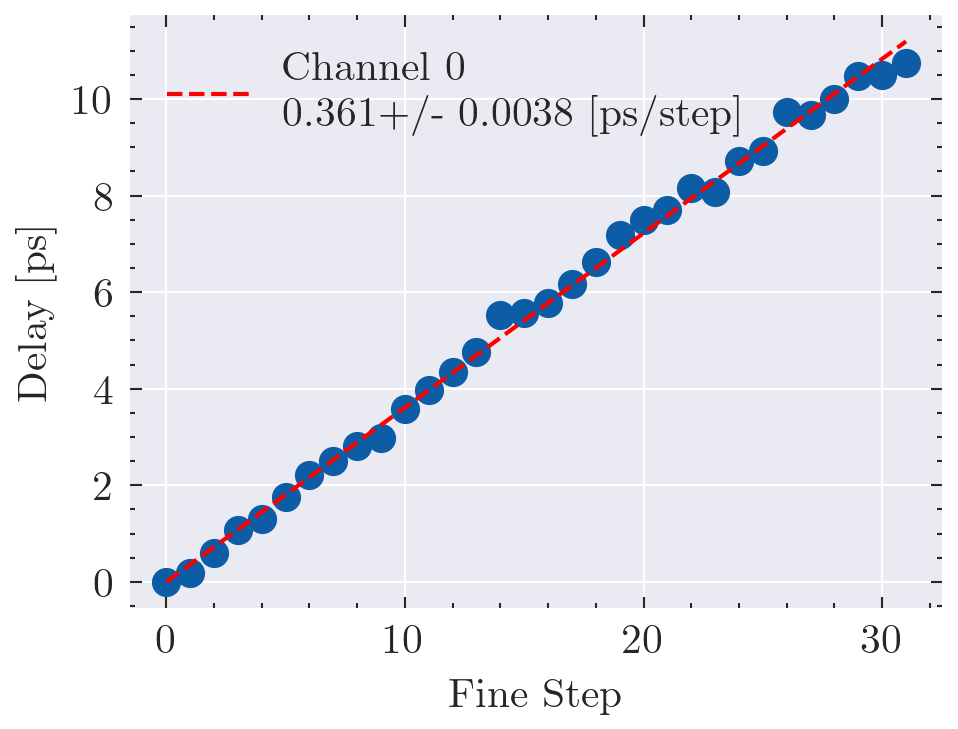

In [243]:
x = np.asarray(X)
y = np.abs(np.asarray(Y) - Y[0])
y_err = np.asarray(Ye)
f,ax = plt.subplots()

popt,pcov = np.polyfit(x,y,1,cov=True)
p_e = np.sqrt(np.diag(pcov))

ax.scatter(x,y)
ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel 0 \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")
ax.set_ylabel("Delay [ps]")
ax.set_xlabel("Fine Step")
ax.legend(loc="upper left",fontsize=10)

In [135]:
# channel = 0
# get_data(0,0,channel=channel,folder=folder_name,aq_iter=100)

In [171]:
folder_name = f"2022_05_01_{freq}MHz"
channel = 0
for i in range(0,32):
    get_data(0,i,channel=channel,folder=folder_name,aq_iter=100)


SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

Done Compiling RPI DCPS
0 fine delay step selected 
0 coarse delay step selected 
0 channel selected 
Selected Fiber 0 edited
1 bit is  0 
2 bit is  0 
3 bit is  0 
4 bit is  0 
5 bit is  0 

32 bits::: MSB: 0000 0000 0000 1111 1000 0011 1110 0000 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1100 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1111 1111 1111 :LSB
 

cmd_buf Forward 
Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8515376 100%    2.76MB/s    0:00:02 (xfer#1, to-check=0/1)

sent 38 bytes  received 85

Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8507101 100%  923.08kB/s    0:00:09 (xfer#1, to-check=0/1)

sent 38 bytes  received 8509284 bytes  810411.62 bytes/sec
total size is 8507101  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd2.txt
     8502871 100%  997.19kB/s    0:00:08 (xfer#1, to-check=0/1)

sent 38 bytes  received 8505054 bytes  895272.84 bytes/sec
total size is 8502871  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd3.txt
     8513738 100%  913.15kB/s    0:00:09 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515921 bytes  811043.71 bytes/sec
total size is 8513738  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use

Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8505690 100%    6.23MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 38 bytes  received 8507873 bytes  3403164.40 bytes/sec
total size is 8505690  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd2.txt
     8512720 100%    9.88MB/s    0:00:00 (xfer#1, to-check=0/1)

sent 38 bytes  received 8514903 bytes  3405976.40 bytes/sec
total size is 8512720  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd3.txt
     8537730 100%    4.11MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 38 bytes  received 8539921 bytes  2439988.29 bytes/sec
total size is 8537730  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.


Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8505631 100%  906.70kB/s    0:00:09 (xfer#1, to-check=0/1)

sent 38 bytes  received 8507814 bytes  810271.62 bytes/sec
total size is 8505631  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd2.txt
     8503777 100%  834.12kB/s    0:00:09 (xfer#1, to-check=0/1)

sent 38 bytes  received 8505960 bytes  739652.00 bytes/sec
total size is 8503777  speedup is 1.00
receiving file list ... 
1 file to consider
ddmtd3.txt
     8513730 100%  683.11kB/s    0:00:12 (xfer#1, to-check=0/1)

sent 38 bytes  received 8515913 bytes  630811.19 bytes/sec
total size is 8513730  speedup is 1.00

SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use

In [172]:
# tie,tie_err = plot_data(0
#                  ,1
#                  ,channel=channel
#                  ,folder=folder_name
#                  ,freq = freq*10**6
#                  ,data_stream = (11,7)
#                  ,draw=True
#                     )

In [ ]:
folder_name = f"2022_05_01_{freq}MHz"

In [230]:
get_data(0,7,channel=channel,folder=folder_name,aq_iter=100)


SSH is enabled and the default password for the 'pi' user has not been changed.
This is a security risk - please login as the 'pi' user and type 'passwd' to set a new password.


Wi-Fi is currently blocked by rfkill.
Use raspi-config to set the country before use.

Done Compiling RPI DCPS
0 fine delay step selected 
7 coarse delay step selected 
0 channel selected 
Selected Fiber 0 edited
1 bit is  1 
2 bit is  1 
3 bit is  1 
4 bit is  0 
5 bit is  0 

32 bits::: MSB: 0000 0000 0000 1100 0001 1111 0000 0111 :LSB
 
32 bits::: MSB: 0000 0000 0000 0000 0000 0000 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1100 0000 0000 :LSB
 
32 bits::: MSB: 1111 1111 1111 1111 1111 1111 1111 1111 :LSB
 

cmd_buf Forward 
Running & Compiling Section
Loading Firmware: 2021_10_11_firmware_v2.4.bit.bin
Running get_data_bram
Firmware Version: 2.4 
 receiving file list ... 
1 file to consider
ddmtd1.txt
     8516529 100%    6.07MB/s    0:00:01 (xfer#1, to-check=0/1)

sent 17582 bytes  received

In [245]:
X  = []
Y  = []
Ye = []
for c_step in range(0,32):
    try:
        tie,tie_err = plot_data(0
             ,c_step
             ,channel=channel
             ,folder=folder_name
             ,freq = freq*10**6
             ,data_stream = (2,10)
             ,draw=False
                )
        X.append(c_step)
        Y.append(tie)
        Ye.append(tie_err)
    except:
        print(f"{c_step} lost")

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [246]:
np.diff(Y)

array([ -7.7267093 ,  -8.83167242,  -7.53074352,  -8.55183338,
        -6.8780786 ,  -7.85425593,  -6.98297616,   1.13585788,
        -6.33651975,  -7.9883558 ,  -6.83757782,  -7.96385106,
        -6.85095333,  -7.20972388,  -6.66586652, -24.46111827,
        -6.83376574,  -6.349368  ,  -6.91027644,  -6.71048848,
        -6.24058436,  -7.04688923,  -6.7022084 ,   1.79691944,
        -6.98664928,  -6.23598387,  -6.68843732,  -5.40140044,
        -6.56669385,  -6.60187565,  -6.27637123])

In [247]:
Y

[904.7647454232422,
 897.0380361211053,
 888.2063637005442,
 880.6756201847509,
 872.1237868079746,
 865.2457082107961,
 857.3914522781297,
 850.4084761169171,
 851.5443339952534,
 845.2078142484758,
 837.2194584488193,
 830.3818806292871,
 822.4180295691659,
 815.5670762364256,
 808.3573523558337,
 801.6914858393993,
 777.2303675656996,
 770.3966018300357,
 764.0472338324357,
 757.1369573968423,
 750.4264689131286,
 744.1858845510075,
 737.1389953258588,
 730.4367869300595,
 732.2337063749382,
 725.2470570971184,
 719.0110732320036,
 712.3226359163909,
 706.9212354809795,
 700.3545416315362,
 693.7526659846221,
 687.4762947574253]

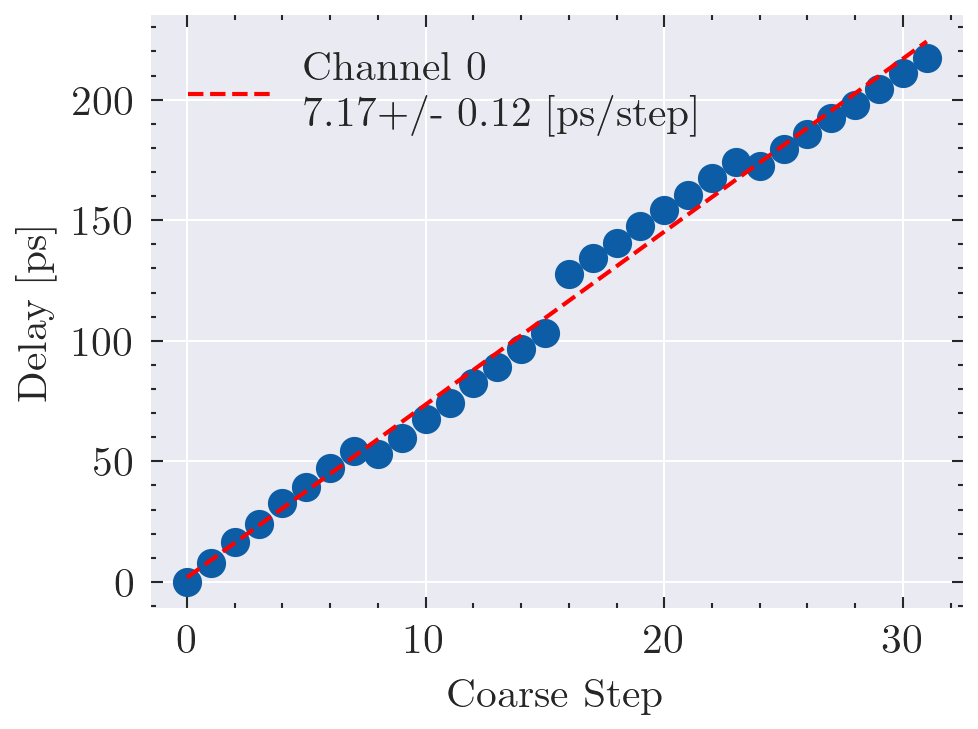

In [233]:
x = np.asarray(X)
y = np.abs(np.asarray(Y) - Y[0])
y_err = np.asarray(Ye)
f,ax = plt.subplots()

popt,pcov = np.polyfit(x,y,1,cov=True)
p_e = np.sqrt(np.diag(pcov))

ax.scatter(x,y)
ax.plot(x,popt[0]*x+popt[1],color="r",linestyle='--',label=f"Channel 0 \n{popt[0]:4.3}+/- {p_e[0]:4.2} [ps/step]")
ax.set_ylabel("Delay [ps]")
ax.set_xlabel("Coarse Step")
ax.legend(loc="upper left",fontsize=10)

In [261]:

X  = []
Y  = []
Ye = []
for c_step in (0,1,2,4,8,16):
    try:
        tie,tie_err = plot_data(0
             ,c_step
             ,channel=channel
             ,folder=folder_name
             ,freq = freq*10**6
             ,data_stream = (2,10)
             ,draw=False
                )
        X.append(c_step)
        Y.append(tie)
        Ye.append(tie_err)
    except:
        print(f"{c_step} lost")

False
False
False
False
False
False


In [262]:
np.abs(Y-Y[0])

array([  0.        ,   7.7267093 ,  16.55838172,  32.64095862,
        53.22041143, 127.53437786])

In [234]:
data = {}
# folder_name = f"2022_04_12_{freq}MHz"
folder_name = f"2022_05_01_{freq}MHz"


for chan in (3,6,7,10,11):
    X  = []
    Y  = []
    Ye = []
    for c_step in (0,16):
        try:
            tie,tie_err = plot_data(0
                 ,c_step
                 ,channel=channel
                 ,folder=folder_name
                 ,freq = freq*10**6
                 ,data_stream = (2,chan)
                 ,draw=False
                    )
            X.append(c_step)
            Y.append(tie)
            Ye.append(tie_err)
        except:
            print(f"{c_step} lost")
    
    data[f"chan{chan}"] = np.asarray((X,Y,Ye))
#2,3
#6,7
#10,11


False
False
False
False
False
False
False
False
False
False


In [169]:
# !open .


In [170]:
for i in data.keys():
    X = data[i][0]*8
    Y = data[i][1]
#     print(Y)
    try:
        print(f"{i}\t{np.abs(np.diff(Y))[0]:5.5f}ps")
    except:
        print(f"{i}   lost")

chan3	6.14082ps
chan6	0.04956ps
chan7	0.51334ps
chan10	0.23408ps
chan11	128.04406ps


In [273]:
# # f,ax = plt.subplots(figsize=(8,6))
# for i in data.keys():
#     f,ax = plt.subplots(figsize=(8,6))

#     X = data[i][0]*8
#     Y = data[i][1]
# #     Ye = data[i][2]
#     ax.scatter(X,Y)
    
#     print(i)
#     ax.set_xlabel("ps")

In [274]:
# data["chan3"][1]

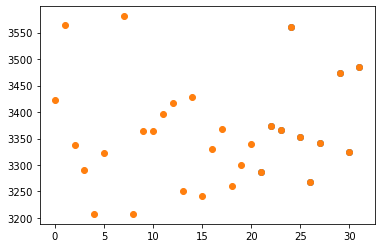

In [122]:
X = np.asarray(data).T[0]
Y = np.asarray(data).T[1]
Ye = np.asarray(data).T[2]



plt.scatter(X[X>20],Y[X>20])
plt.scatter(X,Y)

In [120]:
data = []
for c_step in range(0,32):
    try:
        tie,tie_err = plot_data(0
                 ,c_step
                 ,channel=10
                 ,folder=folder_name
                 ,freq = freq*10**6
                 ,data_stream = (2,6)
                 ,draw=False
                    )
        data.append((c_step,tie,tie_err))
    except:
        print(f"{c_step} lost")
#2,3
#6,7
#10,11



False
False
False
3 lost
False
False
6 lost
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [130]:
# folder_name = f"2022_04_14_{freq}MHz"
# for i in range(0,32):
#     get_data(i,0,channel=10,folder=folder_name,aq_iter=100)